In [164]:
import pandas as pd
import numpy as np
import fasttext

# Memuat dataset
train_df = pd.read_excel('NER DATASETS.xlsx', sheet_name='All')


# hilangkan label entity yang ambigu pada kolom entity dan barisnya
#train_df = train_df[~train_df['entity'].isin(['I-LO', 'O O', 'B-PER O', 'I-PER O', 'O ', 'P'])]
#test_df = test_df[~test_df['entity'].isin(['I-LO', 'O O', 'B-PER O', 'I-PER O', 'O ', 'P'])]

In [165]:
import numpy as np
import os, sys, re
import time
import fasttext
import logging
import xml.etree.ElementTree as ET
import pandas as pd

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, InputLayer
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import Constant

import matplotlib.pyplot as plt

In [166]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100182 entries, 0 to 100181
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Entitas  100152 non-null  object
 1   Label    92485 non-null   object
dtypes: object(2)
memory usage: 1.5+ MB


In [167]:
# buat index untuk kalimat data train

sentence_index = 0
sentence_indices = []
for word in train_df['Entitas']:
    if word == '.':
        sentence_index += 1
    sentence_indices.append(sentence_index)

train_df.insert(0, 'Sentence Index', sentence_indices)

In [170]:
# # buat index untuk kalimat data test

# sentence_index = 0
# sentence_indices = []
# for word in test_df['Entitas']:
#     if word == '.':
#         sentence_index += 1
#     sentence_indices.append(sentence_index)

# test_df.insert(0, 'Sentence Index', sentence_indices)

In [171]:
train_df

,Sentence Index,Entitas,Label
0,0,dinding,B-WIS
1,0,friwenm,I-WIS
2,0,keindahan,O
3,0,raja,I-LOC
4,0,ampat,I-LOC
...,...,...,...
100177,7203,senopati,I-LOC
100178,7203,jakarta,I-LOC
100179,7203,timur,I-LOC
100180,7203,kawasan,I-LOC


In [172]:
# test_df

In [173]:
train_df.isna().sum()

Sentence Index       0
Entitas             30
Label             7697
dtype: int64

In [174]:
train_df.dropna(inplace=True)
# test_df.dropna(inplace=True)

In [175]:
train_df['Label'].unique()

array(['B-WIS', 'I-WIS', 'O', 'I-LOC', 'B-LOC', 'I-SUA', 'WIS', 'I-FAS',
       'o', 'B-FAS', 'OO', 'I-WIIS', 'B-SUA', ' O', 'I', 'O-', 'U-SUA',
       'I-WISO', ' ', 'I0W', 'P', 'IL', 'I-W'], dtype=object)

In [176]:
train_df.loc[train_df['Label'] == 'WIS', 'Label'] = 'I-WIS'
train_df.loc[train_df['Label'] == ' O', 'Label'] = 'O'
train_df.loc[train_df['Label'] == 'o', 'Label'] = 'O'
train_df.loc[train_df['Label'] == 'OO', 'Label'] = 'O'
train_df.loc[train_df['Label'] == 'U-SUA', 'Label'] = 'I-SUA'
train_df.loc[train_df['Label'] == 'O-', 'Label'] = 'O'
train_df.loc[train_df['Label'] == 'I-WIIS', 'Label'] = 'I-WIS'
train_df.loc[train_df['Label'] == 'I', 'Label'] = 'O'
train_df.loc[train_df['Label'] == 'I-W', 'Label'] = 'I-WIS'
train_df.loc[train_df['Label'] == 'I0W', 'Label'] = 'I-WIS'
train_df.loc[train_df['Label'] == 'IL', 'Label'] = 'I-LOC'
train_df.loc[train_df['Label'] == 'P', 'Label'] = 'O'
train_df.loc[train_df['Label'] == ' ', 'Label'] = 'O'

In [177]:
train_df['Label'].unique()

array(['B-WIS', 'I-WIS', 'O', 'I-LOC', 'B-LOC', 'I-SUA', 'I-FAS', 'B-FAS',
       'B-SUA', 'I-WISO'], dtype=object)

In [178]:
test_df['Label'].unique()

array(['B-WIS', 'O', 'I-WIS', 'I-LOC', 'I-SUA', 'B-LOC', 'I-FAS', 'B-SUA',
       'B-FAS'], dtype=object)

In [179]:
test_df.loc[test_df['Label'] == 'I-WISO', 'Label'] = 'I-WIS'
test_df.loc[test_df['Label'] == 'OO', 'Label'] = 'O'
test_df.loc[test_df['Label'] == 'o', 'Label'] = 'O'
test_df.loc[test_df['Label'] == 'P', 'Label'] = 'O'
test_df.loc[test_df['Label'] == ' O', 'Label'] = 'O'

In [180]:
test_df['Label'].unique()

array(['B-WIS', 'O', 'I-WIS', 'I-LOC', 'I-SUA', 'B-LOC', 'I-FAS', 'B-SUA',
       'B-FAS'], dtype=object)

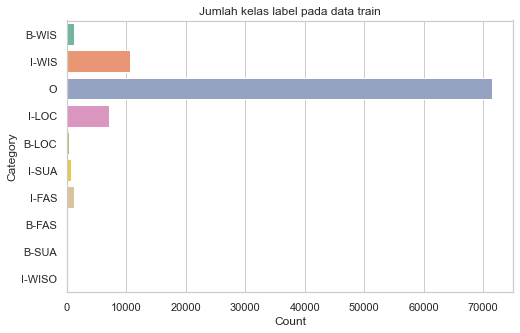

In [181]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))
sns.countplot(y=train_df['Label'], palette="Set2")  # Gunakan 'y' untuk countplot horizontal
plt.xlabel("Count")
plt.ylabel("Category")
plt.title("Jumlah kelas label pada data train")
plt.show()

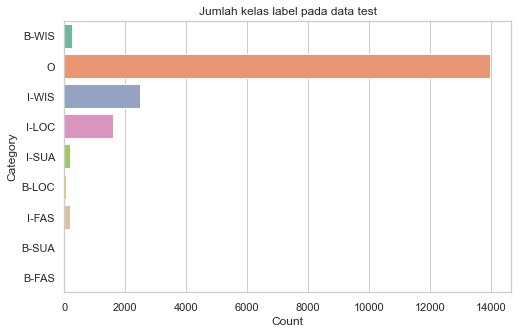

In [182]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))
sns.countplot(y=test_df['Label'], palette="Set2")  # Gunakan 'y' untuk countplot horizontal
plt.xlabel("Count")
plt.ylabel("Category")
plt.title("Jumlah kelas label pada data test")
plt.show()

In [183]:
len(train_df['Label'])

92464

In [187]:
# len(test_df['Label'])

In [188]:
print(f"{train_df.shape}")
# print(f"{test_df.shape}")

(92464, 3)


In [189]:
sentences = train_df["Sentence Index"].values[-1] + 1

In [190]:
def get_dict_map(train_df, token_or_tag):
    tok2idx = {}
    idx2tok = {}

    if token_or_tag == 'token':
        vocab = [''] + list(set(train_df['Entitas'].to_list()))
    else:
        vocab = [''] + list(set(train_df['Label'].to_list()))

    idx2tok = {idx:tok for  idx, tok in enumerate(vocab)}
    tok2idx = {tok:idx for  idx, tok in enumerate(vocab)}
    return tok2idx, idx2tok


token2idx, idx2token = get_dict_map(train_df, 'token')
tag2idx, idx2tag = get_dict_map(train_df, 'tag')

In [191]:
def get_dict_map(train_df, token_or_tag):
    tok2idx = {}
    idx2tok = {}

    if token_or_tag == 'token':
        vocab = [''] + list(set(train_df['Entitas'].to_list()))
    else:
        vocab = [''] + list(set(train_df['Label'].to_list()))

    idx2tok = {idx:tok for  idx, tok in enumerate(vocab)}
    tok2idx = {tok:idx for  idx, tok in enumerate(vocab)}
    return tok2idx, idx2tok


token2idx, idx2token = get_dict_map(train_df, 'token')
lemma2idx, idx2lemma = get_dict_map(train_df, 'lemma')
pos2idx, idx2pos = get_dict_map(train_df, 'pos')
tag2idx, idx2tag = get_dict_map(train_df, 'tag')

In [192]:
tag2idx

{'': 0,
 'I-FAS': 1,
 'B-WIS': 2,
 'I-WIS': 3,
 'O': 4,
 'B-LOC': 5,
 'B-SUA': 6,
 'B-FAS': 7,
 'I-SUA': 8,
 'I-LOC': 9,
 'I-WISO': 10}

In [193]:
train_df

,Sentence Index,Entitas,Label
0,0,dinding,B-WIS
1,0,friwenm,I-WIS
2,0,keindahan,O
3,0,raja,I-LOC
4,0,ampat,I-LOC
...,...,...,...
100177,7203,senopati,I-LOC
100178,7203,jakarta,I-LOC
100179,7203,timur,I-LOC
100180,7203,kawasan,I-LOC


In [194]:
train_df['Entitas Index'] = train_df['Entitas'].map(token2idx)
train_df['Label Index'] = train_df['Label'].map(tag2idx)

In [195]:
train_df

,Sentence Index,Entitas,Label,Entitas Index,Label Index
0,0,dinding,B-WIS,1328,2
1,0,friwenm,I-WIS,5998,3
2,0,keindahan,O,6170,4
3,0,raja,I-LOC,4697,9
4,0,ampat,I-LOC,1424,9
...,...,...,...,...,...
100177,7203,senopati,I-LOC,3485,9
100178,7203,jakarta,I-LOC,1315,9
100179,7203,timur,I-LOC,7387,9
100180,7203,kawasan,I-LOC,6289,9


In [196]:
# Fill na
df_fillna = train_df.fillna(method='ffill', axis=0)
# Groupby and collect columns
df_group = df_fillna.groupby(
['Sentence Index'],as_index=False
)['Entitas', 'Label', 'Entitas Index', 'Label Index'].agg(lambda x: list(x))
# Visualise data
df_group.head()

C:\Users\Itzzgvry\AppData\Local\Temp\ipykernel_13608\130365209.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_group = df_fillna.groupby(


,Sentence Index,Entitas,Label,Entitas Index,Label Index
0,0,"[dinding, friwenm, keindahan, raja, ampat, tak...","[B-WIS, I-WIS, O, I-LOC, I-LOC, O, O, I-WIS, I...","[1328, 5998, 6170, 4697, 1424, 1486, 109, 5473...","[2, 3, 4, 9, 9, 4, 4, 3, 3, 3, 3, 3]"
1,1,"[mengutip, situs, raja, ampat, geopark, raja, ...","[O, O, I-WIS, I-WIS, I-WIS, I-WIS, I-WIS, O, O...","[7145, 821, 4697, 1424, 3141, 4697, 1424, 7550...","[4, 4, 3, 3, 3, 3, 3, 4, 4, 4, 9, 4, 3, 3, 4, ..."
2,2,"[labuan, bajo, dikenal, surga, tersembunyi, in...","[B-LOC, I-LOC, O, O, O, I-LOC, I-LOC, I-LOC]","[654, 5009, 5660, 4662, 2188, 7386, 3329, 7387]","[5, 9, 4, 4, 4, 9, 9, 9]"
3,3,"[desa, berada, kecamatan, komodo, kabupaten, m...","[B-LOC, O, I-LOC, I-LOC, I-LOC, I-LOC, I-LOC, ...","[3057, 794, 436, 3269, 4268, 5619, 2591, 2959,...","[5, 4, 9, 9, 9, 9, 9, 9, 9, 9, 9, 4, 9, 9, 9, ..."
4,4,"[mengutip, situs, kemlu, labuan, bajo, menjadi...","[O, O, O, I-LOC, I-LOC, O, O, O, O, O, O, O, O]","[7145, 821, 1445, 654, 5009, 4774, 5868, 5588,...","[4, 4, 4, 9, 9, 4, 4, 4, 4, 4, 4, 4, 4]"


In [197]:
df_group.tail()

,Sentence Index,Entitas,Label,Entitas Index,Label Index
7199,7199,"[advertisement, kepala, bidang, destinasi, pen...","[O, O, O, O, O, O, O, B-LOC, I-LOC, O, O, O, O...","[2282, 6756, 6059, 5868, 7420, 4232, 5314, 235...","[4, 4, 4, 4, 4, 4, 4, 5, 9, 4, 4, 4, 4, 4, 4, ..."
7200,7200,"[tinggal, kemudian, pihaknya, mendorong, dinas...","[O, O, O, O, O, O, B-LOC, O, O, O]","[1869, 4948, 2728, 245, 2626, 6818, 2356, 5271...","[4, 4, 4, 4, 4, 4, 5, 4, 4, 4]"
7201,7201,"[kawasan, direkomendasikan, jakarta, utara, ka...","[O, O, B-LOC, O, O, O, O]","[6289, 3078, 1315, 610, 6289, 4710, 1627]","[4, 4, 5, 4, 4, 4, 4]"
7202,7202,"[kawsan, jakarta, barat, kawasan]","[O, B-LOC, O, O]","[5669, 1315, 2591, 6289]","[4, 5, 4, 4]"
7203,7203,"[kawasan, jakarta, pusat, cikini, jalan, medan...","[I-LOC, I-LOC, O, I-LOC, O, I-LOC, I-LOC, O, I...","[6289, 1315, 1167, 4054, 3195, 2339, 4264, 467...","[9, 9, 4, 9, 4, 9, 9, 4, 9, 9, 9, 9, 9, 9, 9, ..."


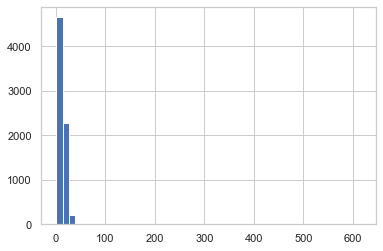

In [198]:
%matplotlib inline
plt.hist([len(s) for s in df_group['Entitas Index']], bins=50) # sentence length histogram
plt.show()

In [216]:
def get_pad_train_dev(df_group, train_df):

    #Pad tokens (X var)
    tokens = df_group['Entitas Index'].tolist()
    maxlen = max([len(s) for s in df_group['Entitas Index']])
    pad_tokens = pad_sequences(tokens, maxlen=maxlen, dtype='int32', value= token2idx[""])

    #Pad Tags (y var) and convert it into one hot encoding
    tags = df_group['Label Index'].tolist()
    pad_tags = pad_sequences(tags, maxlen=maxlen, dtype='int32', value= tag2idx["O"])
    n_tags = len(tag2idx)
    pad_tags_ = [to_categorical(i, num_classes=n_tags) for i in pad_tags]

    #Split train and dev set
    train_tokens, dev_tokens, train_tags, dev_tags = train_test_split(pad_tokens, pad_tags_, test_size = 0.1, train_size =0.9, random_state=42)

    print(
        'train_tokens length:', len(train_tokens),
        '\ndev_tokens length:', len(dev_tokens),
        '\ntrain_tags:', len(train_tags),
        '\ndev_tags:', len(dev_tags),
    )

    return np.array(train_tokens), np.array(dev_tokens), np.array(train_tags), np.array(dev_tags)

train_tokens_, dev_tokens_, train_tags_, dev_tags_ = get_pad_train_dev(df_group, train_df)

train_tokens length: 6483 
dev_tokens length: 721 
train_tags: 6483 
dev_tags: 721


This is how the data can be converted back to human-readable form.

In [217]:
[(idx2token[x], idx2tag[np.argmax(y)]) for x, y in zip(train_tokens_[641], train_tags_[641]) if idx2token[x]]

[('jakarta', 'B-LOC'),
 ('objek', 'O'),
 ('wisata', 'O'),
 ('indonesia', 'I-LOC'),
 ('tak', 'O'),
 ('terhingga', 'O'),
 ('jumlahnya', 'O')]

Neural Network Parameters

In [218]:
input_dim = len(list(set(train_df['Entitas'].to_list())))+1 # vocab length + padding
output_dim = 64
input_length = train_tokens_.shape[1] # max example length
n_tags = len(tag2idx)
print('input_dim: ', input_dim, '\noutput_dim: ', output_dim, '\ninput_length: ', input_length, '\nn_tags: ', n_tags)

input_dim:  8013 
output_dim:  64 
input_length:  616 
n_tags:  11


In [219]:
 # This takes ~2 mins.
 %time embeddings = fasttext.load_model('cc.id.300.bin')

CPU times: total: 2.7 s
Wall time: 1min 12s


In [220]:
# Prepare embedding matrix
hits = misses = 0 # in case of FastText all tokens should be covered
embedding_matrix = np.zeros((len(token2idx), embeddings.get_dimension()))
for word, i in token2idx.items():
    embedding_vector = embeddings[word]
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 8013 words (0 misses)


## Neural Network Architecture

We use BiLSTM & LSTM with dropouts. You can experiment with this. A larger network does not always bring better results.

For the output layer, we use softmax and categorical crossentropy loss - this is the most suitable setting for categorization tasks.

In the Embedding layer, we use the FastText weights as inputs.

Since the sequences are padded with zeros, it is extremely easy for the net to learn these paddings. On the other hand, this information is not useful in the evaluation. For this reason, we use the masking of zeros, so they do not contribute to the evaluation calculation. (If you switch ``mask_zero`` to ``False``, your net will have 99% accuracy without being better than a masked net.

In [221]:
model = Sequential()

# Add Embedding layer
model.add(Embedding(input_dim=input_dim, output_dim=embeddings.get_dimension(), input_length=input_length, embeddings_initializer=Constant(embedding_matrix), trainable=True, mask_zero=True))
#model.add(Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length, trainable=True, mask_zero=True))

model.add(Dropout(0.5))
# Add BiLSTM
model.add(Bidirectional(LSTM(units=output_dim*2, return_sequences=True), merge_mode = 'concat'))

model.add(Dropout(0.5))
model.add(LSTM(units=output_dim, return_sequences=True))

# Add timeDistributed Layer
model.add(TimeDistributed(Dense(n_tags, activation="softmax")))

#Optimiser
adam = Adam(lr=0.005, beta_1=0.9, beta_2=0.999)

# Compile model
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
#model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 616, 300)          2403900   
                                                                 
 dropout_2 (Dropout)         (None, 616, 300)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 616, 256)         439296    
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 616, 256)          0         
                                                                 
 lstm_3 (LSTM)               (None, 616, 64)           82176     
                                                                 
 time_distributed_1 (TimeDis  (None, 616, 11)          715       
 tributed)                                            

c:\Users\Itzzgvry\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [222]:
len(train_tokens_)

6483

In [223]:
# Training: It takes several minutes.
hist = model.fit(train_tokens_, train_tags_, batch_size=64, verbose=1, epochs=5, validation_split=0.1)

Epoch 1/5
92/92 [==============================] - 194s 2s/step - loss: 0.0134 - accuracy: 0.8131 - val_loss: 0.0075 - val_accuracy: 0.8980
Epoch 2/5
92/92 [==============================] - 308s 3s/step - loss: 0.0055 - accuracy: 0.9216 - val_loss: 0.0048 - val_accuracy: 0.9311
Epoch 3/5
92/92 [==============================] - 299s 3s/step - loss: 0.0038 - accuracy: 0.9423 - val_loss: 0.0040 - val_accuracy: 0.9395
Epoch 4/5
92/92 [==============================] - 305s 3s/step - loss: 0.0030 - accuracy: 0.9526 - val_loss: 0.0037 - val_accuracy: 0.9428
Epoch 5/5
92/92 [==============================] - 248s 3s/step - loss: 0.0026 - accuracy: 0.9604 - val_loss: 0.0038 - val_accuracy: 0.9437


## Sample predictions on the train set

Below, you can see predictions on the train set. Not surprisingly, they are correct.

**TASK 2** Modify the code to display dev set predictions. Comment on what you see.

**OPTIONAL TASK** Evaluate the network on the dev set. What entities are easy to recognize? Which are hard?

In [228]:
i = 0

#[(idx2token[x], idx2tag[np.argmax(y)]) for x, y in zip(train_tokens_[103], train_tags_[103]) if idx2token[x]]

for sample, annotation in zip(train_tokens_, train_tags_):
  ex=sample.reshape((1, sample.shape[0]))
  prediction = model.predict(ex)
  ner = np.squeeze(np.argmax(prediction, axis=-1)[:len(sample)])
  print([(idx2token[x], idx2tag[np.argmax(y)], idx2tag[z]) for x, y, z in zip(sample, annotation, ner) if idx2token[x]])
  i += 1
  if i == 10:
    break

1/1 [==============================] - 0s 118ms/step
[('adapun', 'O', 'O'), ('tujuannya', 'O', 'O'), ('mengoptimalisasi', 'O', 'O'), ('berbagai', 'O', 'O'), ('potensi', 'O', 'O'), ('menggerakan', 'O', 'O'), ('roda', 'O', 'O'), ('perekonomian', 'O', 'O'), ('indonesia', 'I-LOC', 'I-LOC')]
1/1 [==============================] - 0s 124ms/step
[('sejalan', 'O', 'O'), ('dorongan', 'O', 'O'), ('pemerintah', 'O', 'O'), ('lewat', 'O', 'O'), ('gerakan', 'O', 'O'), ('nasional', 'O', 'O'), ('bangga', 'O', 'O'), ('buatan', 'O', 'O'), ('indonesia', 'I-LOC', 'I-LOC'), ('gernas', 'O', 'O'), ('bbi', 'O', 'O')]
1/1 [==============================] - 0s 119ms/step
[('dufan', 'B-WIS', 'B-WIS'), ('sendiri', 'O', 'O'), ('dikenal', 'O', 'O'), ('salah', 'O', 'O'), ('satu', 'O', 'O'), ('pusat', 'O', 'O'), ('rekreasi', 'O', 'O'), ('hiburan', 'O', 'O'), ('terbesar', 'O', 'O'), ('indonesia', 'I-LOC', 'I-LOC'), ('menyediakan', 'O', 'O'), ('kawasan', 'O', 'O'), ('konsep', 'O', 'O'), ('fantasi', 'O', 'O'), ('menakju

In [229]:
i = 0

#[(idx2token[x], idx2tag[np.argmax(y)]) for x, y in zip(train_tokens_[103], train_tags_[103]) if idx2token[x]]

for sample, annotation in zip(dev_tokens_, dev_tags_):
  ex=sample.reshape((1, sample.shape[0]))
  prediction = model.predict(ex)
  ner = np.squeeze(np.argmax(prediction, axis=-1)[:len(sample)])
  print([(idx2token[x], idx2tag[np.argmax(y)], idx2tag[z]) for x, y, z in zip(sample, annotation, ner) if idx2token[x]])
  i += 1
  if i == 10:
    break

1/1 [==============================] - 0s 177ms/step
[('merdeka', 'B-WIS', 'B-WIS'), ('walk', 'I-WIS', 'I-WIS'), ('dikenal', 'O', 'O'), ('pusat', 'O', 'O'), ('kuliner', 'O', 'O'), ('objek', 'O', 'O'), ('wisata', 'O', 'O'), ('medan', 'I-LOC', 'I-LOC')]
1/1 [==============================] - 0s 125ms/step
[('urusan', 'O', 'O'), ('akomodasi', 'O', 'O'), ('jauh', 'O', 'O'), ('tempat', 'O', 'O'), ('wisata', 'O', 'O'), ('beberapa', 'O', 'O'), ('hotel', 'I-FAS', 'I-FAS'), ('penginapan', 'I-FAS', 'I-FAS'), ('singgahi', 'O', 'O')]
1/1 [==============================] - 0s 125ms/step
[('rumah', 'I-FAS', 'O'), ('besar', 'O', 'O'), ('memiliki', 'O', 'O'), ('ukuran', 'O', 'O'), ('sebesar', 'O', 'O'), ('8000', 'O', 'O'), ('mÂ²', 'O', 'O'), ('dalamnya', 'O', 'O'), ('terbagi', 'O', 'O'), ('35', 'O', 'O'), ('ruangan', 'O', 'O'), ('kamu', 'O', 'O'), ('telusuri', 'O', 'O'), ('berkunjung', 'O', 'O')]
1/1 [==============================] - 0s 125ms/step
[('kawasan', 'O', 'O'), ('terkenal', 'O', 'O'), ('obj

## Test dengan data baru

In [282]:
my_sentence = "Keindahan Eropa memiliki banyak gunung indah dan banyak spot foto"
encoded = [token2idx.get(t, 0) for t in my_sentence.split()] + [0] * input_length
print("OOV:", [t for t in my_sentence.split() if t not in token2idx])
encoded = encoded[:input_length]

sample = np.array(encoded).reshape((1, input_length))
prediction = model.predict(sample)
ner = np.squeeze(np.argmax(prediction, axis=-1)[:len(my_sentence.split())])
print([(t, idx2tag[n]) for t, n in zip(my_sentence.split(), ner)])

OOV: ['Keindahan', 'Eropa']
1/1 [==============================] - 0s 102ms/step
[('Keindahan', 'O'), ('Eropa', 'O'), ('memiliki', 'O'), ('banyak', 'O'), ('gunung', 'I-WIS'), ('indah', 'I-SUA'), ('dan', 'O'), ('banyak', 'O'), ('spot', 'I-FAS'), ('foto', 'I-FAS')]
